Initial input shape: torch.Size([1, 350, 56])
Input shape after permute for conv layers: torch.Size([1, 56, 350])
Shape after conv layer 0: torch.Size([1, 64, 175])
Shape after conv layer 1: torch.Size([1, 64, 87])
Shape after conv layer 2: torch.Size([1, 64, 43])
Shape after conv layer 3: torch.Size([1, 64, 21])
Shape after conv layer 4: torch.Size([1, 64, 10])
Feature maps shape (last conv layer output): torch.Size([1, 64, 10])
Shape before LSTM: torch.Size([1, 10, 64])
Shape after LSTM: torch.Size([1, 10, 64])
Attention output shape: torch.Size([1, 10, 64])
Logits: tensor([[-2.4346,  0.0518,  2.2126]], grad_fn=<AddmmBackward0>)
Output shape after FC layer: torch.Size([1, 3])
Probabilities: tensor([[0.0085, 0.1024, 0.8890]], grad_fn=<SoftmaxBackward0>)
Initial input shape: torch.Size([1, 350, 56])
Input shape after permute for conv layers: torch.Size([1, 56, 350])
Shape after conv layer 0: torch.Size([1, 64, 175])
Shape after conv layer 1: torch.Size([1, 64, 87])
Shape after conv lay

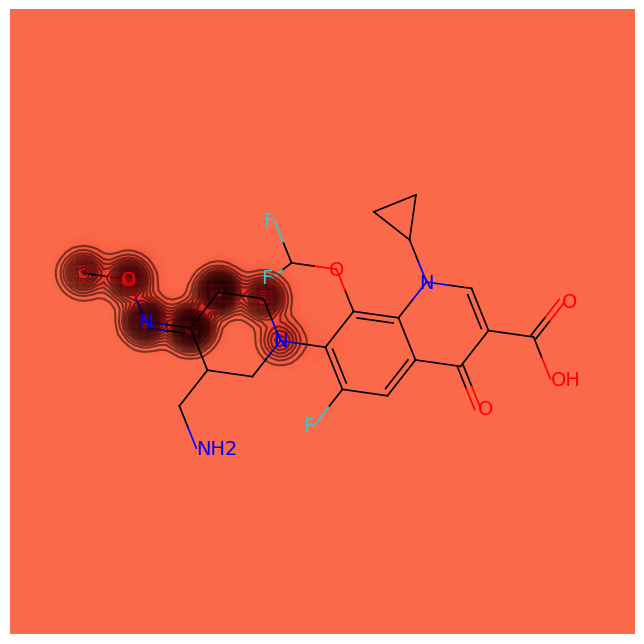

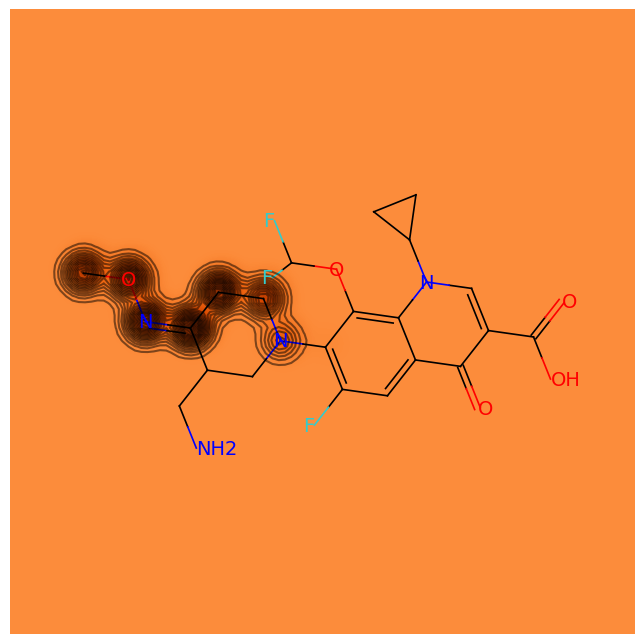

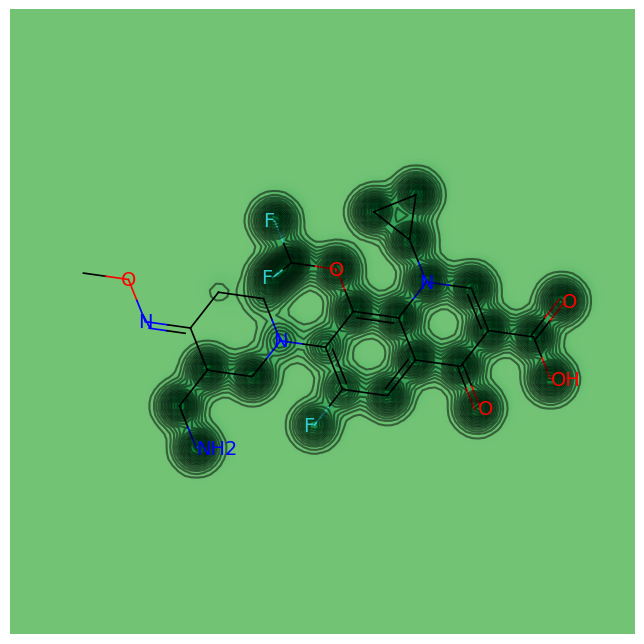

In [2]:
import torch
import numpy as np
from torch.autograd import Function
import torch.nn.functional as F
from model import ConvLSTMCAMbiotic
from rdkit.Chem import Descriptors
from data_preprocessing2 import smiles_chars
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.Draw import DrawingOptions
import matplotlib.cm as cm
import matplotlib.colors as cc
import os
import matplotlib.colors as mcolors
from rdkit.Chem.Draw import SimilarityMaps
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from PIL import Image


# Define the functions for removing backgrounds
def remove_background_green(input_image_path, output_image_path):
    image = Image.open(input_image_path)
    image = image.convert("RGBA")
    data = image.getdata()
    new_data = []
    for item in data:
        if item[1] in range(185, 256):  # Targeting the green channel
            new_data.append((255, 255, 255, 255))  # Replace with white
        else:
            new_data.append(item)
    image.putdata(new_data)
    image.save(output_image_path)

def remove_background_red(input_image_path, output_image_path):
    image = Image.open(input_image_path)
    image = image.convert("RGBA")
    data = image.getdata()
    new_data = []
    for item in data:
        if item[0] in range(200, 256):  # Targeting the red channel
            new_data.append((255, 255, 255, 255))  # Replace with white
        else:
            new_data.append(item)
    image.putdata(new_data)
    image.save(output_image_path)

def smiles_to_tensor(smile, char_to_index, maxlen=350):
    """
    Convert a single SMILES string to a PyTorch tensor.
    
    Args:
    - smile (str): The SMILES string to be converted.
    - char_to_index (dict): A dictionary mapping characters to indices.
    - maxlen (int): Maximum length of the sequence to be padded to.
    
    Returns:
    - torch.Tensor: A PyTorch tensor representing the one-hot encoded SMILES.
    """
    # Convert the SMILES string to a one-hot encoded sequence
    encoded = np.zeros((maxlen, len(char_to_index)), dtype=np.int8)
    for i, char in enumerate(smile):
        if i < maxlen:  # Ensure index doesn't exceed maxlen - 1
            if char in char_to_index:
                encoded[i, char_to_index[char]] = 1
        else:
            break  # Break the loop if index equals or exceeds maxlen
    
    # Convert the numpy array to a PyTorch tensor
    encoded_tensor = torch.from_numpy(encoded).unsqueeze(0)  # Add batch dimension
    encoded_tensor = encoded_tensor.to(dtype=torch.float32)  # Model might expect float
    return encoded_tensor

# Calculate molecular weight using RDKit
def calculate_molecular_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.ExactMolWt(mol) if mol else None

# Filter single SMILES string based on specified criteria
def filter_single_smile(smile, maxlen=350, max_mol_wt=650):
    reasons = []
    mol_wt = calculate_molecular_weight(smile)
    
    if len(smile) > maxlen:
        reasons.append('maxlen exceeded')
    if not all(char in smiles_chars for char in smile):
        reasons.append('invalid character')
    if mol_wt is None or mol_wt > max_mol_wt:
        reasons.append('mol wt exceeded')
    
    return ', '.join(reasons) if reasons else 'valid'

# Main prediction function that incorporates SMILES filtering
def predict_smiles(model, smile, maxlen=350, max_mol_wt=650):
    filter_result = filter_single_smile(smile, maxlen, max_mol_wt)
    
    if filter_result != 'valid':
        print(f"This SMILES cannot be predicted because: {filter_result}.")
        return None, None

    char_to_index = {char: idx for idx, char in enumerate(smiles_chars)}
    input_tensor = smiles_to_tensor(smile, char_to_index, maxlen).to(model.device)

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        logits = model(input_tensor)[0]  # Adjusted to reflect new model output
        probabilities = F.softmax(logits, dim=1).cpu().numpy()[0]  # Get the first (and only) prediction's probabilities
        predicted_class_index = np.argmax(probabilities)
        predicted_probability = probabilities[predicted_class_index]
    
    # Define class labels in the order they are output by the model
    classes = ["Inactive", "Slightly Active", "Active"]
    prediction_message = f"{smile} probabilities: {probabilities} -> Predicted to be {classes[predicted_class_index]} by {predicted_probability:.3f} or {predicted_probability*100:.1f}%"
    print(prediction_message)
    return predicted_class_index, probabilities






class ConvLSTMCAMVisualizerGradCAM:
    def __init__(self, model, device='cpu'):
        # Load the model
        self.model = model
        self.model.eval()  # Set the model to evaluation mode
        self.model.to(device)
        self.device = device

    def prepare_input(self, smiles):
        # Assuming char_to_index is a dictionary mapping SMILES characters to integer indices
        char_to_index = {char: idx for idx, char in enumerate(smiles_chars)}
        smiles_tensor = smiles_to_tensor(smiles, char_to_index, maxlen=350).to(self.device)
        return smiles_tensor

    def grad_cam(self, input_tensor, target_class_index):
        self.model.eval()  # Ensure the model is in evaluation mode.
        self.model.zero_grad()  # Reset gradients to zero.

        logits, _, feature_maps = self.model(input_tensor)
        feature_maps.requires_grad_(True)  # Enable gradients for the feature maps

        # Compute softmax probabilities
        probabilities = F.softmax(logits, dim=1)
        # Select the probability of the target class for visualization
        class_prob = probabilities[:, target_class_index]

        # Backpropagate the target class probability
        self.model.zero_grad()
        class_prob.backward(gradient=torch.ones_like(class_prob))

        gradients = feature_maps.grad.data
        pooled_gradients = torch.mean(gradients, dim=[0, 2], keepdim=True)

        for i in range(feature_maps.size(1)):  # Iterate over the channels
            feature_maps.data[:, i, :] *= pooled_gradients[:, i, :]

        heatmap = torch.mean(feature_maps.data, dim=1).squeeze()
        heatmap = F.relu(heatmap)  # Use only positive influences
        heatmap /= torch.max(heatmap)  # Normalize the heatmap

        return heatmap.cpu().numpy()



   
    def interpolate_heatmap_to_atoms(self, smiles, heatmap): #Adding self to the method signature allows you to call other methods within this method and access class attributes showinng that it is an instance method
        """Interpolate the heatmap to match the number of atoms in the molecule."""
        # Convert SMILES to RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)
        # Get the number of atoms
        num_atoms = mol.GetNumAtoms()

        # Create an interpolation function
        interpolate = interp1d(np.arange(len(heatmap)), heatmap, fill_value="extrapolate")
        
        # Generate new heatmap values that match the number of atoms
        new_heatmap = interpolate(np.linspace(0, len(heatmap) - 1, num_atoms))
        
        return new_heatmap    





        

    def overlay_heatmap_on_molecule(self, smiles, heatmap, output_image_path, cmap):
        # Convert SMILES to RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)

        # Normalize the heatmap
        norm = Normalize(vmin=min(heatmap), vmax=max(heatmap))

        # Generate and save the similarity map
        fig, ax = plt.subplots()
        fig.patch.set_facecolor('white')
        SimilarityMaps.GetSimilarityMapFromWeights(mol, [norm(value) for value in heatmap], colorMap=plt.get_cmap(cmap), contourLines=20) # you can play with the contour lines to get the best visualization
        plt.axis('off')
        plt.savefig(output_image_path, bbox_inches='tight')
        plt.close(fig)


    def visualize_combined_heatmap(self, smiles, cmaps=('Reds', 'Oranges', 'Greens')):
        input_tensor = self.prepare_input(smiles)
        
        # Generate heatmaps for each class
        inactive_heatmap = self.grad_cam(input_tensor, 0)  # For visualizing inactive
        slightly_active_heatmap = self.grad_cam(input_tensor, 1)  # For visualizing slightly active
        active_heatmap = self.grad_cam(input_tensor, 2)  # For visualizing active

        # Interpolate heatmaps to match the number of atoms in the molecule
        interpolated_inactive = self.interpolate_heatmap_to_atoms(smiles, inactive_heatmap)
        interpolated_slightly_active = self.interpolate_heatmap_to_atoms(smiles, slightly_active_heatmap)
        interpolated_active = self.interpolate_heatmap_to_atoms(smiles, active_heatmap)

        # Overlay and visualize heatmaps for each class
        self.overlay_heatmap_on_molecule(smiles, interpolated_inactive, 'inactive_heatmap.png', cmap=cmaps[0])
        self.overlay_heatmap_on_molecule(smiles, interpolated_slightly_active, 'slightly_active_heatmap.png', cmap=cmaps[1])
        self.overlay_heatmap_on_molecule(smiles, interpolated_active, 'active_heatmap.png', cmap=cmaps[2])


        # # Remove backgrounds and save new images
        # remove_background_green('original_heatmap_positive_GradCAM.png', 'processed_heatmap_positive_GradCAM.png')
        # remove_background_red('original_heatmap_negative_GradCAM.png', 'processed_heatmap_negative_GradCAM.png')


if __name__ == "__main__":
    

    model_checkpoint_path = 'Seed Randomization_SA/models500/checkpoint-epoch=198-val_loss=0.67.ckpt' # replace with model checkpoint path 
    trained_model = ConvLSTMCAMbiotic.load_from_checkpoint(model_checkpoint_path)
    trained_model.eval()  # Set the model to evaluation mode
    visualizer = ConvLSTMCAMVisualizerGradCAM(trained_model, device='cuda' if torch.cuda.is_available() else 'cpu') # Move model to the appropriate device

    # Uncomment the SMILES string you want to visualize
    smiles ='CO/N=C1\CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(C4CC4)c3c2OC(F)F)CC1CN'# ACTIVE molecule example, change SMILES  to your own molecule


    visualizer.visualize_combined_heatmap(smiles, cmaps=('Reds', 'Oranges', 'Greens'))
    prediction, probabilities = predict_smiles(trained_model, smiles)



